In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

In [2]:
from networks import GGDRiskFieldNetwork

In [3]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import normalize

In [4]:
# read spacing data from all recordings
data_path = "D:/Productivity/Paper/RSS2024-Journal/data"
data = pd.concat([ pd.read_csv(f"{data_path}/{r:02}_spacings_2.csv",index_col=0) for r in trange(1,61)])

100%|██████████| 60/60 [00:08<00:00,  7.38it/s]


In [5]:
vehicle_mean_speed = data.groupby(['ego_id','recording_id']).ego_xVel.transform('mean')
vehicle_abs_speed = vehicle_mean_speed.abs() 
data['dir'] = vehicle_mean_speed / vehicle_abs_speed

In [6]:
ego_pre_lc = data.groupby(['ego_id','recording_id']).ego_pre_lc.transform('any')
ego_post_lc = data.groupby(['ego_id','recording_id']).ego_post_lc.transform('any')
ego_lc = ego_pre_lc | ego_post_lc

foe_pre_lc = data.groupby(['foe_id','recording_id']).foe_pre_lc.transform('any')
foe_post_lc = data.groupby(['foe_id','recording_id']).foe_post_lc.transform('any')
foe_lc = foe_pre_lc | foe_post_lc


data['ego_lc'] = ego_lc
data['foe_lc'] = foe_lc

In [7]:
ggd = GGDRiskFieldNetwork(8)

In [8]:
data.columns, len(data)

(Index(['ego_x', 'ego_y', 'foe_x', 'foe_y', 'ego_length', 'foe_length',
        'ego_width', 'foe_width', 'ego_truck', 'foe_truck', 'ego_pre_lc',
        'foe_pre_lc', 'ego_post_lc', 'foe_post_lc', 'ego_xVel', 'ego_yVel',
        'ego_xAccel', 'ego_yAccel', 'foe_xVel', 'foe_yVel', 'foe_xAccel',
        'foe_yAccel', 'y_marker1', 'y_marker2', 'y_bound1', 'y_bound2',
        'recording_id', 'ego_id', 'foe_id', 'frame', 'dir', 'ego_lc', 'foe_lc'],
       dtype='object'),
 6457619)

In [9]:
'''
sample input: (8)
<ego.vx> <ego.vy> <ego.vx-foe.vx> <ego.vy-foe.vy> <ego.pre_lc or ego.post_lc> <foe.pre_lc or foe.post_lc> <ego.class> <foe.class>
'''

'\nsample input: (8)\n<ego.vx> <ego.vy> <ego.vx-foe.vx> <ego.vy-foe.vy> <ego.pre_lc or ego.post_lc> <foe.pre_lc or foe.post_lc> <ego.class> <foe.class>\n'

In [10]:
ego_xVel = np.abs(data.ego_xVel.values)
ego_yVel = np.abs(data.ego_yVel.values) * data.dir.values
rel_xVel = -((data.ego_xVel - data.foe_xVel)*(data.ego_x - data.foe_x) / abs(data.ego_x - data.foe_x)).values
rel_yVel = -((data.ego_yVel - data.foe_yVel)*(data.ego_y - data.foe_y) / abs(data.ego_y - data.foe_y)).values
ego_lc = data.ego_lc
foe_lc = data.foe_lc
ego_class = data.ego_truck.values
foe_class = data.foe_truck.values

In [11]:
X = np.clip( abs(data.ego_x - data.foe_x) -  0.5*(data.ego_length - data.foe_length), a_min=0, a_max=None).values *((data.foe_x - data.ego_x) / abs(data.ego_x - data.foe_x)).values * data.dir.values
Y = np.clip( abs(data.ego_y - data.foe_y) -  0.5*(data.ego_width - data.foe_width), a_min=0, a_max=None).values *((data.foe_y - data.ego_y) / abs(data.ego_y - data.foe_y)).values * data.dir.values
np.nan_to_num(X, 0)
np.nan_to_num(Y, 0)

array([ 0.  ,  0.  ,  0.  , ..., -3.51, -3.5 , -3.48])

In [12]:
X = torch.Tensor(X).to('cuda').detach()
Y = torch.Tensor(Y).to('cuda').detach()

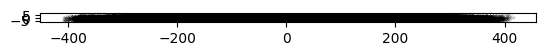

In [13]:
plt.scatter(X.cpu().numpy(), Y.cpu().numpy(), color='black', s=0.01)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

In [14]:
Input = np.array(
    [
        ego_xVel, ego_yVel, rel_xVel, rel_yVel, ego_lc, foe_lc, ego_class, foe_class
    ]

).T
np.nan_to_num(Input, 0)
Input = torch.Tensor(Input)

In [15]:
Input[:,0] = Input[:,0] / torch.quantile(Input[:,0], 0.95)
Input[:,1] = Input[:,1] / 1
Input[:,2] = Input[:,2] / 15
Input[:,2] = Input[:,2] / 1.25
samples = Input.cpu().numpy()

In [16]:
dataset = torch.cat([Input.to('cuda'), X.view(-1,1)], dim=1)
dataset = torch.cat([dataset.to('cuda'), Y.view(-1,1)], dim=1)
dataset.shape

torch.Size([6457619, 10])

In [ ]:
dataset

In [17]:
print (np.where(dataset.cpu().numpy()[:,3]>0.3)[0][18500:19500])

[281011 281013 281015 281017 281135 281195 281196 281197 281204 281205
 281207 281208 281210 281211 281213 281214 281216 281217 281219 281220
 281222 281223 281225 281226 281228 281229 281231 281232 281234 281235
 281237 281238 281241 281243 281286 281618 281619 281620 281621 281622
 281623 281624 281625 281626 281627 281628 281629 281838 281839 281840
 281841 281842 281843 281844 281845 281928 281929 281930 281947 281949
 281951 281953 281955 281957 281982 281983 281984 281985 281986 281987
 281988 281989 281990 281991 282045 282046 282047 282048 282049 282087
 282089 282091 282093 282094 282095 282096 282097 282148 282149 282150
 282151 282152 282185 282186 282187 282188 282189 282203 282204 282205
 282206 282207 282208 282209 282210 282211 282212 282213 282214 282215
 282216 282217 282218 282219 282339 282340 282341 282342 282343 282344
 282345 282346 282347 282348 282349 282478 282479 282481 282482 282483
 282484 282485 282486 282487 282488 282489 282490 282491 282492 282493
 28250

In [174]:
query_point = dataset[282862,0:8]
query_point 

tensor([ 0.9740, -0.1700, -0.0107,  0.3200,  0.0000,  0.0000,  0.0000,  0.0000],
       device='cuda:0')

In [175]:
def find_neighbors_brute_force(data, query_point, epsilon, epsilon_1=0.2):
    """
    Find all points in 'data' within 'epsilon' distance of 'query_point' using brute-force search.
    """
    distances = torch.norm(data[:,[0,1,2,3,4,6,7]] - query_point[[0,1,2,3,4,6,7]], dim=1)  # Compute Euclidean distances
    indices = torch.where(distances <= epsilon)[0]  # Get indices within epsilon range
    if len(indices) < 100 and epsilon_1 > epsilon:
        indices = torch.where(distances <= epsilon_1)[0]
    return indices, data[indices]  # Return indices and actual neighbor points



In [176]:
def find_neighbors_batch(data, query_point, epsilon=0.1, epsilon_1=0.15, mu=100, search_dims=[0,1,2,3,4,6,7], batch_size=10000, return_neighboars=False):
    """
    Find all points in 'data' within 'epsilon' distance of 'query_point' using brute-force search.
    """
    num_samples = data.shape[0]
    indices_list = [] 
    for i in range(0, num_samples, batch_size):
        bound = i + batch_size if i+batch_size < num_samples else num_samples
        batch = data[i:bound] 
        distances = torch.norm(batch[:,search_dims] - query_point[search_dims], dim=1)
        mask = distances <= epsilon
        found_indices = torch.nonzero(mask, as_tuple=True)[0] + i
        indices_list.append(found_indices)
    indices = torch.cat(indices_list) if indices_list else torch.tensor([])
    if len(indices)<mu and epsilon<epsilon_1:
        indices = find_neighbors_batch(data, query_point, epsilon=epsilon_1, epsilon_1=epsilon_1, mu=mu, search_dims=search_dims, batch_size=batch_size)
    return [indices, data[indices]] if return_neighboars else indices



In [177]:
def find_neighbors_adjacent_matrix(data, query_point, epsilon=0.1, epsilon_1=0.15, mu=100, search_dims=[0,1,2,3,4,6,7], batch_size=10000, return_neighboars=False):
    """
    Find all points in 'data' within 'epsilon' distance of 'query_point' using brute-force search.
    """
    num_samples = data.shape[0]
    adj_matrix = torch.zeros(len(data), len(data)).to(data.device)
    for i in range(0, num_samples, batch_size):
        bound = i + batch_size if i+batch_size < num_samples else num_samples
        batch = data[i:bound] 
        distances = torch.norm(batch[:,search_dims] - query_point[search_dims], dim=1)
        mask = distances <= epsilon
        found_indices = torch.nonzero(mask, as_tuple=True)[0] + i
        adj_matrix[i][found_indices] = 1
    if len(indices)<mu and epsilon<epsilon_1:
        indices = find_neighbors_batch(data, query_point, epsilon=epsilon_1, epsilon_1=epsilon_1, mu=mu, search_dims=search_dims, batch_size=batch_size)
    return [indices, data[indices]] if return_neighboars else indices

In [29]:
# Query Point & Radius
epsilon = 0.1
epsilon_1 = 0.15
# 
max_sample = 500000
# Find neighbors
status = [1,0,0]
subset = dataset
for c,cl in enumerate([4,6,7]):
    subset = subset[subset[:,cl]==status[c]]
# get a lite version of data
_key = np.random.choice(range(len(subset)),min(len(subset), max_sample))
subset = subset[_key]
adj = [ find_neighbors_adjacent_matrix(subset[:,0:8], subset[k,0:8], epsilon, epsilon_1, batch_size=500000) for k in trange(len(subset))]

  0%|          | 0/439590 [00:00<?, ?it/s]


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 772957472400 bytes.

In [213]:
len(subset), len(dataset)

(3504545, 6457619)

In [214]:
# Query Point & Radius
epsilon = 0.1
# get a lite version of data
_key = np.random.choice(range(len(subset)),int(len(subset)*0.30))
subset = subset[_key]
len(subset)

1051363

In [178]:
# Find neighbors
indices, neighbors = find_neighbors_batch(dataset[:,0:8], query_point, epsilon, 0.15)
len(indices)

NameError: name 'epsilon' is not defined

In [184]:
Indices_ = [ find_neighbors_brute_force(subset[:,0:8], subset[k,0:8], epsilon)[0] for k in trange(len(subset))]


  3%|▎         | 30383/969669 [00:11<06:06, 2565.40it/s]


KeyboardInterrupt: 

In [61]:
subset.shape

torch.Size([34919, 10])

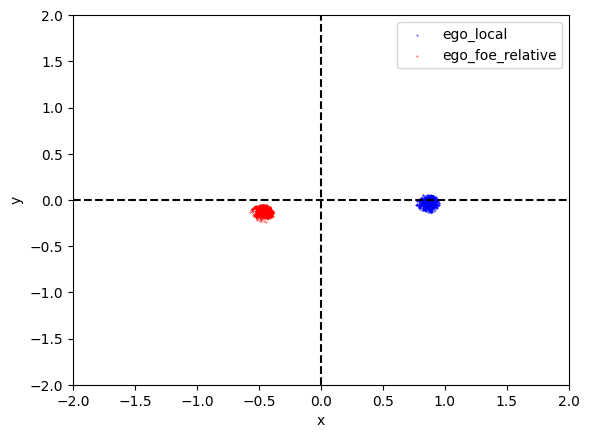

In [223]:
plt.scatter(neighbors[:,0], neighbors[:,1], color='blue', s=0.1, label='ego_local')
plt.scatter(neighbors[:,2], neighbors[:,3], color='red', s=0.1, label='ego_foe_relative')
plt.axhline(0, linestyle='dashed', color='black')
plt.axvline(0, linestyle='dashed', color='black')
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [224]:
xs = dataset[indices][:,8]
ys = dataset[indices][:,9]

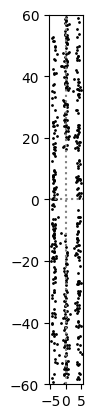

In [225]:
plt.scatter(ys.cpu(), xs.cpu(), color='black', s=1)
plt.ylim(-60, 60)
plt.axhline(0, linestyle='dotted', color='grey')
plt.axvline(0, linestyle='dotted', color='grey')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

In [16]:
def euclidean_distance(x1, x2):
    return torch.sqrt(torch.sum((x1 - x2) ** 2, dim=1))

def dbscan(X, eps, min_samples):
  
    n_samples = X.shape[0]
    labels = torch.zeros(n_samples, dtype=torch.int)

    # Initialize cluster label and visited flags
    cluster_label = 0
    visited = torch.zeros(n_samples, dtype=torch.bool)

    # Iterate over each point
    for i in trange(n_samples):
        if visited[i]:
            continue
        visited[i] = True

        # Find neighbors
        neighbors = torch.nonzero(euclidean_distance(X[i], X) < eps).squeeze()
        
        if neighbors.shape[0] < min_samples:
            # Label as noise
            labels[i] = 0
        else:
            # Expand cluster
            cluster_label += 1
            labels[i] = cluster_label
            expand_cluster(X, labels, visited, neighbors, cluster_label, eps, min_samples)

    return labels

def expand_cluster(X, labels, visited, neighbors, cluster_label, eps, min_samples):
    i = 0
    while i < neighbors.shape[0]:
        neighbor_index = neighbors[i].item()
        if not visited[neighbor_index]:
            visited[neighbor_index] = True
            neighbor_neighbors = torch.nonzero(euclidean_distance(X[neighbor_index], X) < eps).squeeze()
            if neighbor_neighbors.shape[0] >= min_samples:
                neighbors = torch.cat((neighbors, neighbor_neighbors))
        if labels[neighbor_index] == 0:
            labels[neighbor_index] = cluster_label
        i += 1

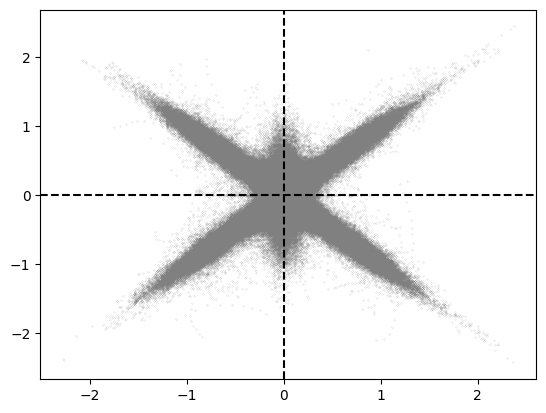

In [401]:
subset = samples[ (samples[:,5]==0) & ((samples[:,6]==0))  ]

plt.scatter(subset[:,1], subset[:,3], color='grey', s=0.01)
plt.axhline(0, linestyle='dashed', color='black')
plt.axvline(0, linestyle='dashed', color='black')

In [122]:
sel = np.random.choice(len(samples),20000)
subsample = samples[sel]

In [156]:
dataset = pd.DataFrame(samples)
dataset['x'] = X
dataset['y'] = Y

In [159]:
subset = dataset[
    (dataset[2]>0) & (dataset[2]<=0.2)
]

In [160]:
subset

,0,1,2,3,4,5,6,7,x,y
6,0.867930,-0.00,0.037333,0.02,0.0,0.0,0.0,0.0,-77.84,0.54
7,0.869283,-0.00,0.037867,0.05,0.0,0.0,0.0,0.0,-77.94,0.54
8,0.870907,-0.00,0.039467,0.08,0.0,0.0,0.0,0.0,-78.11,0.56
9,0.872260,-0.01,0.040000,0.11,0.0,0.0,0.0,0.0,-78.25,0.58
10,0.873342,-0.02,0.041067,0.12,0.0,0.0,0.0,0.0,-78.42,0.61
...,...,...,...,...,...,...,...,...,...,...
6457574,0.987280,-0.01,0.022400,-0.04,0.0,0.0,0.0,0.0,87.35,-2.92
6457575,0.985927,-0.02,0.021867,-0.03,0.0,0.0,0.0,0.0,87.42,-2.90
6457576,0.984303,-0.03,0.021333,-0.02,0.0,0.0,0.0,0.0,87.48,-2.90
6457577,0.982679,-0.04,0.020800,-0.02,0.0,0.0,0.0,0.0,87.58,-2.90


In [74]:
subsample.shape

(20000, 4)

In [35]:
dbscan = DBSCAN(eps=0.2, min_samples=10)

In [36]:
labels = dbscan.fit_predict(subsample)

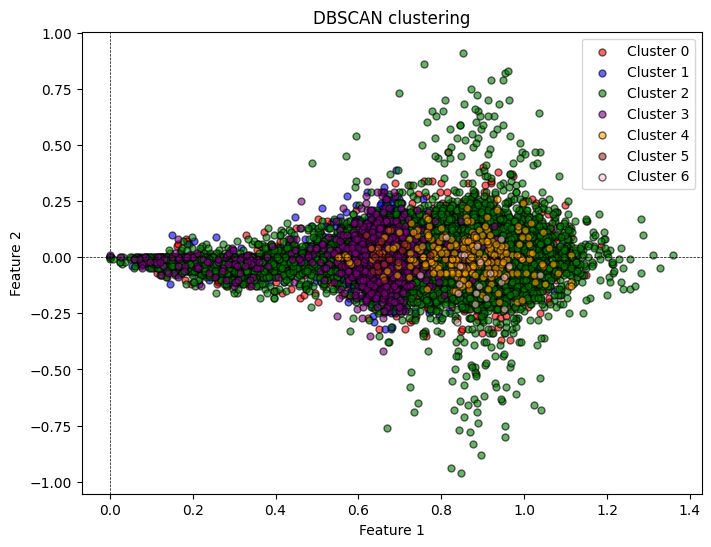

In [39]:
plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink']
for label, color in zip(unique_labels, colors):
    if label == -1:
        color = 'black'
        label_text = "Noise"
    else:
        label_text = f"Cluster {label}"
    
    plt.scatter(subsample[labels == label, 0], subsample[labels == label, 1], c=color, label=label_text, alpha=0.6, edgecolors='k', s=25)
plt.axhline(0, linestyle='dashed', color='black', linewidth=0.5)
plt.axvline(0, linestyle='dashed', color='black', linewidth=0.5)
plt.legend()
plt.title("DBSCAN clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [75]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=100, covariance_type='full')
gmm.fit(subsample)

GaussianMixture(n_components=100)

In [76]:
labels = gmm.predict(subsample)

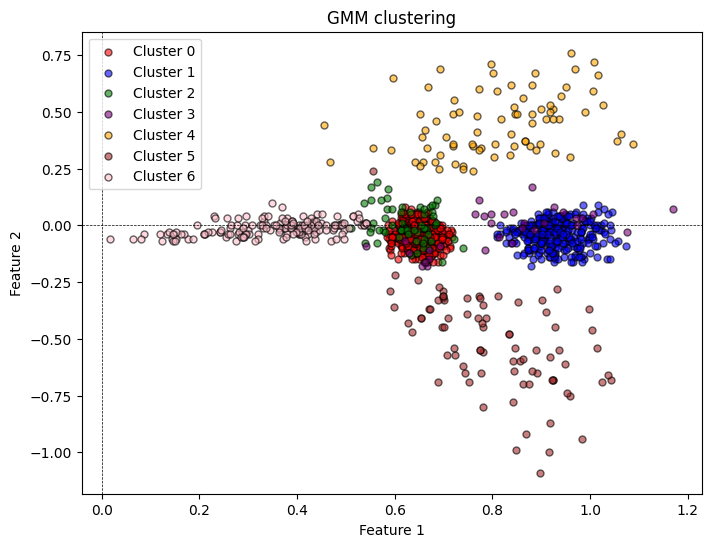

In [78]:
plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink']
for label, color in zip(unique_labels, colors):
    if label == -1:
        color = 'black'
        label_text = "Noise"
    else:
        label_text = f"Cluster {label}"
    
    plt.scatter(subsample[labels == label, 0], subsample[labels == label, 1], c=color, label=label_text, alpha=0.6, edgecolors='k', s=25)
plt.axhline(0, linestyle='dashed', color='black', linewidth=0.5)
plt.axvline(0, linestyle='dashed', color='black', linewidth=0.5)
plt.legend()
plt.title("GMM clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

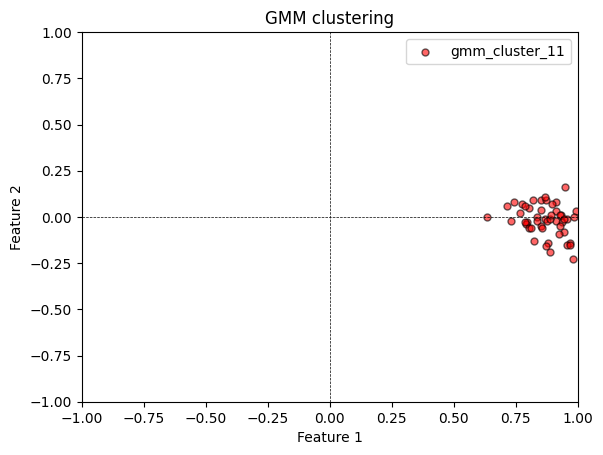

In [107]:
_label = 11
plt.scatter(subsample[labels == _label, 0], subsample[labels == _label, 1], c='red', label=f"gmm_cluster_{_label}", alpha=0.6, edgecolors='k', s=25)
plt.axhline(0, linestyle='dashed', color='black', linewidth=0.5)
plt.axvline(0, linestyle='dashed', color='black', linewidth=0.5)
plt.legend()
plt.title("GMM clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.show()

In [16]:
trainset = Input[0:1000].to('cuda')

In [153]:
test_x = torch.full([len(trainset)], 10).to('cuda') + 3+ 3*torch.randn((len(trainset))).to('cuda')
test_y = torch.full([len(trainset)], 2).to('cuda')+ 2+ 2*torch.randn((len(trainset))).to('cuda')
test_x, test_y

(tensor([16.3263, 18.1438, 18.5576, 12.2930, 14.7440, 12.4872, 12.6849, 11.9995,
         11.3073, 15.6896, 17.7269, 14.6784, 13.8440, 10.9385, 18.0211, 16.1197,
          8.3450, 15.7275, 10.7183, 11.1700, 10.2733, 10.5138, 16.1094, 11.8822,
         14.8056, 13.5044, 12.3307, 10.0460, 10.2209, 12.5399, 17.9827,  5.4005,
          6.8842, 11.3568,  6.2721, 17.4948, 11.8021,  8.3239, 12.6367, 15.8554,
         13.6677, 12.3515, 20.8817, 21.9202, 15.7534, 14.0272, 10.5171, 16.2396,
         12.7325,  9.1047, 13.4774,  8.2961,  7.7638, 12.2166, 11.1382, 10.6650,
         14.5911,  6.0818, 16.2182, 12.1545, 12.7892, 10.8646,  7.4729,  7.6791,
          9.8111, 10.6350, 11.9917, 10.0311,  9.5500, 15.1703, 15.6431, 11.7905,
         15.0002, 15.5577, 10.3976, 12.1351,  9.1108, 12.1812, 12.6704, 11.4223,
         11.3782, 12.8577, 12.3461, 16.0794,  8.3532, 11.8250, 17.0170, 19.1050,
         12.2283, 11.5067, 19.0313, 15.5679, 11.0862, 10.4221, 13.7939, 11.6786,
         15.1968, 11.8677, 1

In [165]:
output = ggd.forward(trainset) + torch.tensor([10,3]).to(trainset.device)
output

tensor([[11.0037,  4.0000],
        [11.0037,  4.0000],
        [11.0037,  4.0000],
        ...,
        [11.0062,  4.0012],
        [11.0023,  4.0000],
        [11.0062,  4.0012]], device='cuda:0', grad_fn=<AddBackward0>)

In [166]:
torch.exp(-torch.abs(test_x/output[:,0])**5-torch.abs(test_y/output[:,1])**5) 

tensor([4.8589e-05, 1.5765e-06, 7.4398e-07, 8.5305e-03, 5.7129e-06, 3.4782e-02,
        7.3059e-03, 3.0424e-18, 2.0160e-01, 1.3032e-03, 8.1523e-30, 1.2314e-03,
        5.6986e-04, 3.7523e-01, 7.3180e-06, 7.5153e-04, 6.2686e-01, 3.3207e-09,
        1.1278e-01, 2.0684e-01, 1.3356e-04, 1.1658e-01, 2.8761e-04, 1.7007e-01,
        5.5909e-03, 4.3506e-06, 1.7082e-01, 5.2509e-01, 3.1374e-01, 4.5364e-04,
        8.0175e-08, 4.5429e-01, 4.6075e-02, 2.6976e-01, 6.2388e-01, 3.0664e-07,
        6.5286e-02, 7.8036e-01, 1.4252e-02, 2.0049e-03, 9.7730e-03, 1.1953e-03,
        2.0394e-11, 9.1279e-15, 9.0601e-18, 1.1274e-02, 4.4986e-01, 8.9648e-04,
        1.2552e-01, 3.8445e-01, 5.2968e-04, 7.7851e-01, 5.8150e-02, 1.8483e-01,
        3.4268e-01, 6.4595e-02, 1.1171e-02, 2.6887e-01, 1.1278e-10, 1.0838e-03,
        1.5881e-03, 1.1782e-01, 3.2213e-01, 3.7147e-04, 4.6002e-01, 3.3968e-01,
        1.7431e-02, 3.1291e-02, 5.9248e-03, 3.1104e-12, 2.6005e-03, 1.0118e-01,
        2.6280e-03, 1.0281e-07, 1.9260e-

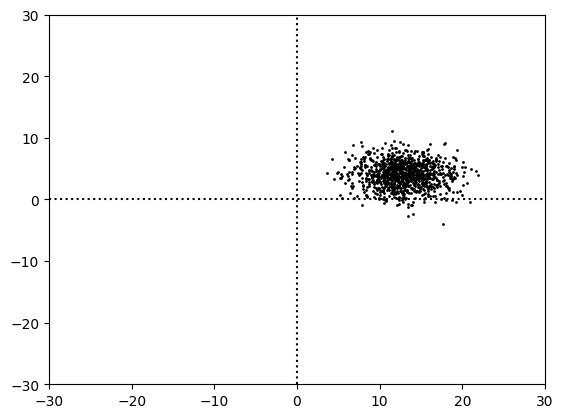

In [167]:
plt.scatter(test_x.cpu().numpy(), test_y.cpu().numpy(), s=1, color='black')
plt.xlim(-30, 30)
plt.ylim(-30, 30)
plt.axvline(0, color='black', linestyle='dotted')
plt.axhline(0, color='black', linestyle='dotted')

In [168]:
k = 105
gx = output[:,0][k]
gy = output[:,1][k]
prob = 1 + 1e-4 - torch.exp(-torch.abs(test_x/gx)**5-torch.abs(test_y/gy)**5) 
log = torch.sum(torch.log(prob))
log

tensor(-142.3339, device='cuda:0', grad_fn=<SumBackward0>)

In [169]:
ux = torch.autograd.grad(log, gx,
                            create_graph=True,
                            allow_unused=True,
                            grad_outputs=torch.ones_like(log)
                          )[0]


uy = torch.autograd.grad(log, gy,
                            create_graph=True,
                            allow_unused=True,
                            grad_outputs=torch.ones_like(log)
                          )[0]
ux, uy

(tensor(-55.4515, device='cuda:0', grad_fn=<SumBackward0>),
 tensor(-57.4868, device='cuda:0', grad_fn=<SumBackward0>))

In [170]:
uux = torch.autograd.grad(ux, gx,
                            create_graph=True,
                            allow_unused=True,
                            grad_outputs=torch.ones_like(ux)
                          )[0]
uuy = torch.autograd.grad(uy, gy,
                            create_graph=True,
                            allow_unused=True,
                            grad_outputs=torch.ones_like(ux)
                          )[0]
uux, uuy

(tensor(-10.9911, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(-3.9481, device='cuda:0', grad_fn=<AddBackward0>))

In [160]:
hessians = torch.cat([uux, uuy], dim=1).reshape(len(uux),2,2)

RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

In [83]:
eval, evec = torch.linalg.eig(hessians[5])

In [84]:
eval, evec

(tensor([0.+0.j, 0.+0.j], device='cuda:0', grad_fn=<LinalgEigBackward0>),
 tensor([[1.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j]], device='cuda:0', grad_fn=<LinalgEigBackward0>))

In [25]:

# Reconstruct H using standard basis [1,0] and [0,1]
H_standard_basis = evec @ torch.diag(eval) @ torch.linalg.inv(evec)

In [28]:
torch.linalg.eig(H_standard_basis) 

torch.return_types.linalg_eig(
eigenvalues=tensor([ 0.0894+0.j, -0.0072+0.j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>),
eigenvectors=tensor([[ 0.7179+0.j,  0.6962+0.j],
        [-0.6962-0.j,  0.7179+0.j]], device='cuda:0',
       grad_fn=<LinalgEigBackward0>))

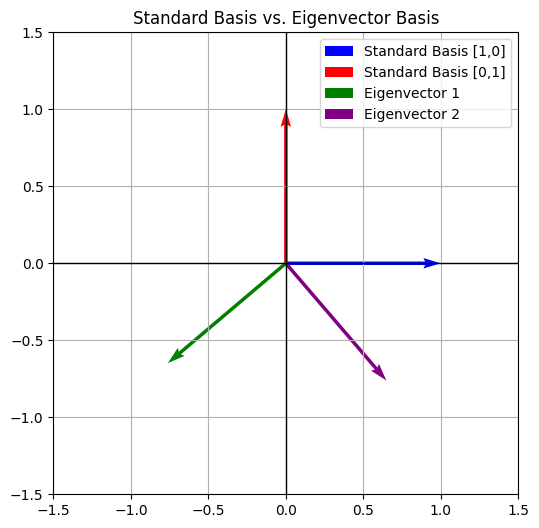

In [37]:


# Define Hessian matrix
H = hessians[8].cpu().detach()
# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = torch.linalg.eig(H)

# Convert to real values (remove imaginary part if any)
eigenvalues = eigenvalues.real
eigenvectors = eigenvectors.real

# Standard basis vectors
standard_basis = torch.tensor([[1.0, 0.0], [0.0, 1.0]])

# Transform standard basis using eigenvectors
transformed_basis = eigenvectors @ standard_basis

# Plot original standard basis
fig, ax = plt.subplots(figsize=(6, 6))
ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

# Plot standard basis [1,0] and [0,1]
ax.quiver(0, 0, 1, 0, angles='xy', scale_units='xy', scale=1, color='blue', label="Standard Basis [1,0]")
ax.quiver(0, 0, 0, 1, angles='xy', scale_units='xy', scale=1, color='red', label="Standard Basis [0,1]")

# Plot eigenvectors as transformed basis
ax.quiver(0, 0, eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='green', label="Eigenvector 1")
ax.quiver(0, 0, eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='purple', label="Eigenvector 2")

ax.legend()
ax.set_title("Standard Basis vs. Eigenvector Basis")
plt.grid()
plt.show()


In [39]:
def test_hessian(x, y, input=[], model=None, _gamma=[0,0], beta=4):
    output = model(input)
    gamma = output + torch.Tensor(_gamma).to(input.device)
    prob = 1 + 1e-4 - torch.exp(-torch.abs(x/gamma[:,0])**beta-torch.abs(y/gamma[:,1])**beta) 
    log = torch.log(prob)
    u = torch.autograd.grad(log, gamma,
                            create_graph=True,
                            allow_unused=True,
                            grad_outputs=torch.ones_like(log)
                          )[0]
    ux = u[:,0]
    uy = u[:,1]
    uux = torch.autograd.grad(ux, gamma,
                            create_graph=True,
                            allow_unused=True,
                            grad_outputs=torch.ones_like(ux)
                          )[0]
    uuy = torch.autograd.grad(uy, gamma,
                                create_graph=True,
                                allow_unused=True,
                                grad_outputs=torch.ones_like(ux)
                              )[0]
    hessians = torch.cat([uux, uuy], dim=1).reshape(len(uux),2,2)
    eval, evec = torch.linalg.eig(hessians[5])
    return torch.real(eval)

In [72]:
gx = 17
gy = 10

_x = 20
_y = 10


G = np.arange(0, 40, 1)
Eval_Xs = []
Eval_Ys = []

for gy in tqdm(G):
    evals = test_hessian(_x, _y, input=trainset, model=ggd, _gamma=[gx,gy])
    Eval_Xs.append(max(evals))
    Eval_Ys.append(min(evals))




100%|██████████| 40/40 [00:00<00:00, 84.79it/s]


(-0.2, 0.2)

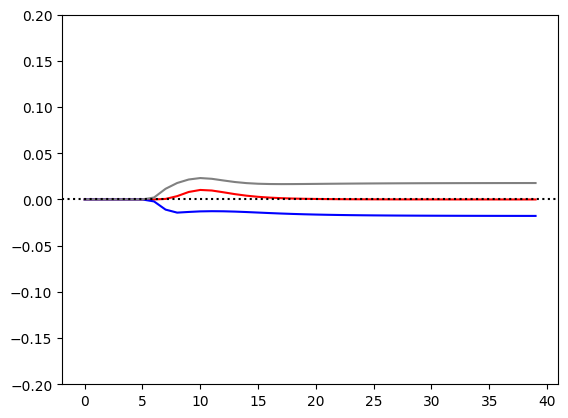

In [74]:
plt.plot(G, torch.Tensor(Eval_Xs), color='red')
plt.plot(G, torch.Tensor(Eval_Ys), color='blue')
plt.plot(G, torch.sqrt((torch.Tensor(Eval_Xs) - torch.Tensor(Eval_Ys))**2), color='grey')
plt.axhline(0, color='black', linestyle='dotted')
plt.ylim(-0.2, 0.2)

(-0.2, 0.2)

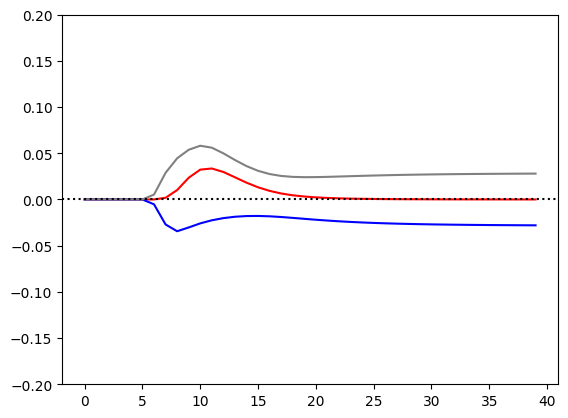

In [30]:
plt.plot(G, torch.Tensor(Eval_Xs), color='red')
plt.plot(G, torch.Tensor(Eval_Ys), color='blue')
plt.plot(G, torch.sqrt((torch.Tensor(Eval_Xs) - torch.Tensor(Eval_Ys))**2), color='grey')
plt.axhline(0, color='black', linestyle='dotted')
plt.ylim(-0.2, 0.2)

In [294]:
eval, evec

(tensor([ 0.0344+0.j, -0.0421+0.j], device='cuda:0',
        grad_fn=<LinalgEigBackward0>),
 tensor([[ 0.7224+0.j,  0.6914+0.j],
         [-0.6914+0.j,  0.7224+0.j]], device='cuda:0',
        grad_fn=<LinalgEigBackward0>))

In [282]:
eval, test_x[5], test_y[5]

(tensor([0.+0.j, 0.+0.j], device='cuda:0', grad_fn=<LinalgEigBackward0>),
 tensor(10.4170, device='cuda:0'),
 tensor(10.5843, device='cuda:0'))

In [267]:
eval

tensor([ 0.0126+0.j, -0.0311+0.j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)

In [190]:
eval

tensor([ 0.0056+0.j, -0.0356+0.j], device='cuda:0',
       grad_fn=<LinalgEigBackward0>)

In [209]:
eval

tensor([0.0009+0.j, 0.0028+0.j], device='cuda:0', grad_fn=<LinalgEigBackward0>)

In [36]:
trainlen = int(len(Input)*0.8)
train, test = torch.utils.data.random_split(Input, [trainlen, len(Input)-trainlen])

In [39]:
len(train), len(test)

(5166095, 1291524)

In [214]:


uuy = torch.autograd.grad(u, output,
                            create_graph=True,
                            allow_unused = True,
                            retain_graph = True
                          )[0]

RuntimeError: grad can be implicitly created only for scalar outputs

In [43]:
N = 5  # Example size
gamma = torch.randn(N, requires_grad=True)
L = gamma**3 + 5 * gamma**2 + 3 * gamma + 7 

In [44]:
grad_L = torch.autograd.grad(L, gamma, create_graph=True,grad_outputs=torch.ones_like(L))[0]
second_derivatives = torch.autograd.grad(grad_L, gamma, grad_outputs=torch.ones_like(grad_L))[0]

In [45]:
second_derivatives

tensor([-4.2414,  7.7726,  7.1548,  9.4131,  6.5169])

tensor([-5.2183,  3.0839,  4.3366,  1.5227, 13.6404], grad_fn=<AddBackward0>)

In [215]:
x = torch.randn(2, requires_grad=True)
t = torch.randn(2, requires_grad=True)
u = 5*x**2 + t**3
u

tensor([ 1.5401, -1.4570], grad_fn=<AddBackward0>)

In [207]:
dt = torch.autograd.grad(u, t)[0]

RuntimeError: grad can be implicitly created only for scalar outputs

In [161]:
torch.min(output[:,0])

tensor(0.1017, device='cuda:0', grad_fn=<MinBackward1>)

In [46]:
from itertools import product
list(product([1,0], repeat=3))

[(1, 1, 1),
 (1, 1, 0),
 (1, 0, 1),
 (1, 0, 0),
 (0, 1, 1),
 (0, 1, 0),
 (0, 0, 1),
 (0, 0, 0)]